<a href="https://colab.research.google.com/github/haonanzhang314/Machine-Learning/blob/master/%E7%9F%A5%E8%AF%86%E8%92%B8%E9%A6%8FKnowledgeDistillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train Epoch : 1	 Loss : 2.303365
Test --Average loss:0.0008,Accuracy : 98.413

Train Epoch : 2	 Loss : 0.026217
Test --Average loss:0.0006,Accuracy : 98.885

Train Epoch : 3	 Loss : 0.075044
Test --Average loss:0.0004,Accuracy : 99.290

Train Epoch : 4	 Loss : 0.027793
Test --Average loss:0.0003,Accuracy : 99.350

Train Epoch : 5	 Loss : 0.013070
Test --Average loss:0.0003,Accuracy : 99.507

Train Epoch : 6	 Loss : 0.039747
Test --Average loss:0.0002,Accuracy : 99.617

Train Epoch : 7	 Loss : 0.025287
Test --Average loss:0.0002,Accuracy : 99.585

Train Epoch : 8	 Loss : 0.008603
Test --Average loss:0.0001,Accuracy : 99.758

Train Epoch : 9	 Loss : 0.005423
Test --Average loss:0.0001,Accuracy : 99.775

Train Epoch : 10	 Loss : 0.007236
Test --Average loss:0.0001,Accuracy : 99.805

Train student kd  Epoch : 1	 Loss : 6.886706


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Test --Average loss:0.1202,Accuracy : 97.550

Train student kd  Epoch : 2	 Loss : 0.330918
Test --Average loss:0.0839,Accuracy : 98.130

Train student kd  Epoch : 3	 Loss : 0.168494
Test --Average loss:0.0523,Accuracy : 98.680

Train student kd  Epoch : 4	 Loss : 0.120905
Test --Average loss:0.0394,Accuracy : 98.915

Train student kd  Epoch : 5	 Loss : 0.096405
Test --Average loss:0.0325,Accuracy : 99.112

Train student kd  Epoch : 6	 Loss : 0.099886
Test --Average loss:0.0267,Accuracy : 99.198

Train student kd  Epoch : 7	 Loss : 0.159521
Test --Average loss:0.0179,Accuracy : 99.505

Train student kd  Epoch : 8	 Loss : 0.067348
Test --Average loss:0.0157,Accuracy : 99.577

Train student kd  Epoch : 9	 Loss : 0.068956
Test --Average loss:0.0162,Accuracy : 99.507

Train student kd  Epoch : 10	 Loss : 0.081318
Test --Average loss:0.0120,Accuracy : 99.647

Train Epoch : 1	 Loss : 2.305423
Test --Average loss:0.0058,Accuracy : 85.457

Train Epoch : 2	 Loss : 0.527182
Test --Average loss:0.

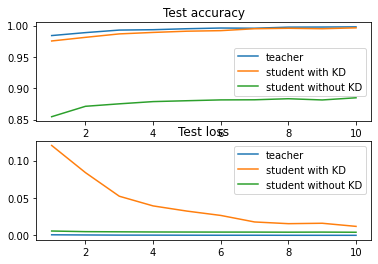

In [7]:
                                        #调用必要的库
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.utils.data
import numpy as np
from matplotlib import pyplot as plt

seed = torch.manual_seed(0)
cuda_seed = torch.cuda.manual_seed(0)       #生成随机种子

#超参数
epoch = 10
batch_size = 64  #batch_size批处理。每次处理的数据数量,
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     #如果有GPU则用GPU训练，否则用cpu训练

#transform转换
transform = transforms.Compose([
    transforms.ToTensor(),    #将图片转换成tensor格式
    transforms.Normalize((0.1307,), (0.3081,))  #正则化，如果不确定取多少值，那就选择这个官网给的值
])

#下载加载数据集
from torch.utils.data import DataLoader
train_set = datasets.MNIST('./MNIST', train=True, download=True, transform=transform)
test_set = datasets.MNIST('./MNIST', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)


###########老师模型###################
class TeacherNet(nn.Module):
    def __init__(self):
        super(TeacherNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout1 = nn.Dropout2d(0.3)     #丢到一些神经元，防止过拟合
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        input_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = x.view(input_size, -1)     #拉平
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        output = self.fc2(x)
        return output

#优化器
model = TeacherNet().to(device)
optimizer = torch.optim.Adadelta(model.parameters())

###########训练老师模型##################

#定义训练的函数方法
def train_teacher(model, device, train_loader, optimizer, epoch):
    #模型训练
    model.train() #调用模型的train方法开始训练
    #batch_index每次读取下标， target是标签例如图片是5,则标签是5.
    for batch_index, (data, target) in enumerate(train_loader):
        #把训练部署到设备上去
        data, target = data.to(device), target.to(device)
        #梯度初始化为0
        optimizer.zero_grad()
        #训练后的结果
        output = model(data)
        #计算损失 损失用function中的函数cross_entropy计算，cross_entropy是交叉熵损失，交叉熵损失适用于多分类的任务
        loss = F.cross_entropy(output, target)
        #找到概率值最大的下标
        pred = output.max(1, keepdim=True)
        #反向传播
        loss.backward()
        #参数的更新优化
        optimizer.step()
        #每隔3000张图片打印一次结果
        if batch_index % 3000 == 0:
            #format是进行格式化的转换
            print("Train Epoch : {}\t Loss : {:.6f}".format(epoch,loss.item()))
############测试老师模型#################
def test_teacher(model, device, test_loader):
    # 模型验证
    model.eval()
    #正确率初始化
    correct = 0.0
    #测试损失初始化
    test_loss = 0.0
    with torch.no_grad():#不计算梯度，也不会进行反向传播
        for data, target in test_loader:
            #部署到device上
            data, target = data.to(device), target.to(device)
            #测试后的结果
            output = model(data)
            #累计测试损失 损失用function中的函数cross_entropy计算，cross_entropy是交叉熵损失，交叉熵损失适用于多分类的任务
            test_loss += F.cross_entropy(output, target).item()
            #找到概率值最大的下标
            pred = output.max(1, keepdim=True)[1]
            #累计正确的值
            correct += pred.eq(target.view_as(pred)).sum().item()
        #测试损失率
        test_loss /= len(test_loader.dataset)
        #正确率
        correct  /= len(test_loader.dataset)
        #{:.4f} 表示小数点后4位
        print("Test --Average loss:{:.4f},Accuracy : {:.3f}\n".format(
            test_loss, 100.0 * correct))
            # correct 是测试正确的  len（test_loader.dataset）是数据集。相除得到正确率
        return test_loss, correct

##############循环运行##################
teacher_history = []
for epoch in range(1, epoch + 1):
    train_teacher(model, device, train_loader, optimizer, epoch)
    loss, acc = test_teacher(model, device, test_loader)
    teacher_history.append((loss, acc))
torch.save(model.state_dict(), "teacher.pt")
teacher_model = model




###############学生模型###############
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = F.relu(self.fc3(x))
        return output


####################优化器#####################
model = StudentNet().to(device)
optimizer = torch.optim.Adadelta(model.parameters())

#蒸馏操作y:学生网络的输出，没有softmax前部分是soft loss(teacher的)，后部分是hard loss(student的)


###########知识蒸馏##########
def distillation(y, labels, teacher_scores, temp, alpha):
    return nn.KLDivLoss()(F.log_softmax(y / temp, dim=1), F.softmax(teacher_scores / temp, dim=1)) * (temp * temp * 2.0 * alpha) \
           + F.cross_entropy(y, labels) * (1. - alpha)


#############知识蒸馏情况下的学生模型训练############
def train_student_kd(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        teacher_output = teacher_model(data)
        teacher_output = teacher_output.detach()  # 切断老师网络的反向传播
        loss = distillation(output, target, teacher_output, temp=5.0, alpha=0.7)
        loss.backward()
        optimizer.step()

        # 每隔3000张图片打印一次结果
        if batch_idx % 3000 == 0:
            # format是进行格式化的转换
            print("Train student kd  Epoch : {}\t Loss : {:.6f}".format(epoch, loss.item()))



##############知识蒸馏情况下的学生模型测试##########3
def test_student_kd(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    correct /= len(test_loader.dataset)
    # {:.4f} 表示小数点后4位
    print("Test --Average loss:{:.4f},Accuracy : {:.3f}\n".format(
        test_loss, 100.0 * correct))
    # correct 是测试正确的  len（test_loader.dataset）是数据集。相除得到正确率
    return test_loss, correct


####################循环运行######################
student_kd_history = []
for epoch in range(1, epoch + 1):
    train_student_kd(model, device, train_loader, optimizer, epoch)
    loss, acc = test_student_kd(model, device, test_loader)
    student_kd_history.append((loss, acc))
torch.save(model.state_dict(), "student_kd.pt")
student_kd_model = model










###############学生模型###############
class Simple_stuNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    def forward(self,x):
        input_size = x.size(0)
        x = x.view(input_size, -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.relu(x)
        return output

####################优化器#####################
model = Simple_stuNet().to(device)
optimizer = torch.optim.Adadelta(model.parameters())

###############无知识蒸馏下的学生模型训练################
def train_student(model, device, train_loader, optimizer, epoch):
    #模型训练
    model.train() #调用模型的train方法开始训练
    #batch_index每次读取下标， target是标签例如图片是5,则标签是5.
    for batch_index, (data, target) in enumerate(train_loader):
        #把训练部署到设备上去
        data, target = data.to(device), target.to(device)
        #梯度初始化为0
        optimizer.zero_grad()
        #训练后的结果
        output = model(data)
        #计算损失 损失用function中的函数cross_entropy计算，cross_entropy是交叉熵损失，交叉熵损失适用于多分类的任务
        loss = F.cross_entropy(output, target)
        #找到概率值最大的下标
        pred = output.max(1, keepdim=True)
        #反向传播
        loss.backward()
        #参数的更新优化
        optimizer.step()
        #每隔3000张图片打印一次结果
        if batch_index % 3000 == 0:
            #format是进行格式化的转换
            print("Train Epoch : {}\t Loss : {:.6f}".format(epoch,loss.item()))
################无知识蒸馏情况下学生模型测试################
# 定义测试方法
def test_student(model, device, test_loader):
    # 模型验证
    model.eval()
    #正确率初始化
    correct = 0.0
    #测试损失初始化
    test_loss = 0.0
    with torch.no_grad():#不计算梯度，也不会进行反向传播
        for data, target in test_loader:
            #部署到device上
            data, target = data.to(device), target.to(device)
            #测试后的结果
            output = model(data)
            #累计测试损失 损失用function中的函数cross_entropy计算，cross_entropy是交叉熵损失，交叉熵损失适用于多分类的任务
            test_loss += F.cross_entropy(output, target).item()
            #找到概率值最大的下标
            pred = output.max(1, keepdim=True)[1]
            #累计正确的值
            correct += pred.eq(target.view_as(pred)).sum().item()
        #测试损失率
        test_loss /= len(test_loader.dataset)
        #正确率
        correct /= len(test_loader.dataset)
        #{:.4f} 表示小数点后4位
        print("Test --Average loss:{:.4f},Accuracy : {:.3f}\n".format(
            test_loss, 100.0 * correct))
            # correct 是测试正确的  len（test_loader.dataset）是数据集。相除得到正确率
        return test_loss, correct
####################循环运行######################
student_simple_history = []
for epoch in range(1, epoch + 1):
    train_student(model, device, train_loader, optimizer, epoch)
    loss, acc = test_student(model, device, test_loader)
    student_simple_history.append((loss, acc))

torch.save(model.state_dict(), "student.pt")
student_simple_model = model









##########展示模块 start##############
import matplotlib.pyplot as plt
epochs = 10
x = list(range(1, epochs+1))

plt.subplot(2, 1, 1)
plt.plot(x, [teacher_history[i][1] for i in range(epochs)], label='teacher')
plt.plot(x, [student_kd_history[i][1] for i in range(epochs)], label='student with KD')
plt.plot(x, [student_simple_history[i][1] for i in range(epochs)], label='student without KD')

plt.title('Test accuracy')
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(x, [teacher_history[i][0] for i in range(epochs)], label='teacher')
plt.plot(x, [student_kd_history[i][0] for i in range(epochs)], label='student with KD')
plt.plot(x, [student_simple_history[i][0] for i in range(epochs)], label='student without KD')

plt.title('Test loss')
plt.legend()

plt.show()
##########展示模块 end#################





